In [2]:
!pip install googletrans==3.1.0a0
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q trl datasets
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip uninstall torch -y
!pip install torch==2.1

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 39.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Found existing installation: torch 2.3.0+cu121
Uninstalling torch-2.3.0+cu121:
  Successfully

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from datasets import load_dataset, load_metric
import accelerate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time
import random

## Preprocessing

In [2]:
train_data_link = 'https://raw.githubusercontent.com/JoyeBright/DeepSentiPers/master/Dataset/original.csv'
test_data_link = 'https://raw.githubusercontent.com/JoyeBright/DeepSentiPers/master/Dataset/test.csv'

In [3]:
train_data = pd.read_csv(train_data_link, header=None)
test_data = pd.read_csv(test_data_link, header=None)

In [4]:
train_data.columns = ['text', 'label']
test_data.columns = ['text', 'label']

In [5]:
train_data.head()

,text,label
0,گوشي خوبيه(قوي و شکيل و زيبا و بي رقيب)البته ت...,1
1,سلام خيلي خوبه بخرين.,2
2,از جمله قابلیت‌های ارتباطی HTC Desire SV می‌تو...,0
3,نهایتا، یک دوربین VGA نیز برای انجام مکالمات ...,0
4,من حدوداً ۱ ماهي‌ که مي‌شه اين گوشي رو دارم، ر...,1


In [6]:
map = {2:2, 1:2, 0:1, -1:0, -2:0}
def map_labels(df):
    df['label'] = df['label'].map(map)
    return df

train_data = map_labels(train_data)
test_data = map_labels(test_data)

Class distribution in train_data:
label
2    2611
1    2409
0     541
Name: count, dtype: int64


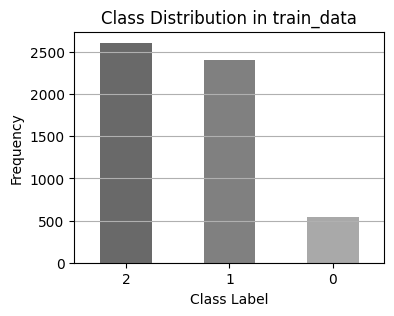

In [7]:
train_label_distribution = train_data['label'].value_counts()
print("Class distribution in train_data:")
print(train_label_distribution)

plt.figure(figsize=(4, 3))
train_label_distribution.plot(kind='bar', color=['dimgrey', 'grey', 'darkgrey'])
plt.title('Class Distribution in train_data')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()

Class distribution in test_data:
label
2    915
1    743
0    196
Name: count, dtype: int64


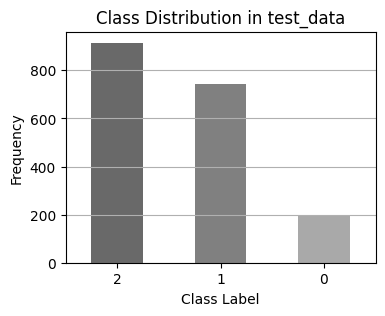

In [8]:
test_label_distribution = test_data['label'].value_counts()
print("Class distribution in test_data:")
print(test_label_distribution)

plt.figure(figsize=(4, 3))
test_label_distribution.plot(kind='bar', color=['dimgrey', 'grey', 'darkgrey'])
plt.title('Class Distribution in test_data')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()

In [9]:
def count_tokens(df):
    return df['text'].apply(lambda x: len(x.split())).sum()

train_tokens_count = count_tokens(train_data)
test_tokens_count = count_tokens(test_data)

print(f'the count of tokens in the train data:\t{train_tokens_count}')
print(f'the count of tokens in the test data:\t{test_tokens_count}')

the count of tokens in the train data:	121893
the count of tokens in the test data:	41354


## Backtranslation

In [10]:
from googletrans import Translator

In [11]:
translator = Translator()

def backtranslate(text, src_lang='fa', mid_lang='en'):
    translated = translator.translate(text, src=src_lang, dest=mid_lang).text
    back_translated = translator.translate(translated, src=mid_lang, dest=src_lang).text
    return back_translated


In [12]:
def augment_data(df):
    augmented_rows = []
    for i, row in df.iterrows():
        original_text = row['text']
        original_label = row['label']
        augmented_text = backtranslate(original_text)
        augmented_rows.append({'text': augmented_text, 'label': original_label})
    augmented_df = pd.DataFrame(augmented_rows)
    combined_df = pd.concat([df, augmented_df], ignore_index=True)
    return combined_df

In [ ]:
train_augmented = augment_data(train_data)

In [17]:
train_data
test_data
train_augmented # contains train data + aug data
aug_data = train_augmented.iloc[int(train_augmented.shape[0]/2) :] # only augmented data

In [82]:
def compare(index):
    print('actual text:',aug_data.iloc[index]['text'])
    print('backtranslated text:', train_data.iloc[index]['text'])

In [94]:
for i in range(20):
    if i % 2 == 1:
        compare(i)

actual text: سلام خیلی خوب بخر
backtranslated text: سلام خيلي خوبه بخرين.
actual text: در نهایت یک دوربین VGA نیز در جلوی گوشی برای مکالمات تصویری تعبیه شده است.
backtranslated text: نهایتا،  یک دوربین VGA نیز برای انجام مکالمات تصویری در قسمت جلویی گوشی تعبیه گردیده است.
actual text: اندازه نسبتا خوب و وزن خوب 4.
backtranslated text: اندازه نسبتاً مناسب و وزن خوب 4.
actual text: من نزدیک به 2 سال است که از این اسکنر استفاده می کنم و کاملا از آن راضی هستم
backtranslated text: تقريبا 2 سال هست که از اين اسکنر استفاده ميکنم و کاملا  از آن راضيم
actual text: سلام

من یک هفته پیش دوربین را خریدم

اولین نکته این است که این دوربین ساخت کشور چین است

دوم اینکه در حالت دستی که رنگ های استاندارد عکاسی کرم و سیاه و سفید دارد نمی توان عکس کرم گرفت و فقط سیاه و سفید و استاندارد را می توان انتخاب کرد.

ثالثا به دلیل قیمتش نمیشه عکس های خوبی گرفت و فقط یک کار استارتاپی هست
backtranslated text: با سلام

من يک هفته است که دوربين رو خريداري کردم

اولين نکته  که اين دوربين ساخت چين است

دوم اينکه در مود

## finetuning

In [20]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset


In [45]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def get_model():
    model_name = "HooshvareLab/bert-fa-zwnj-base"
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
    device = 'cuda'
    model = model.to(device)
    return model

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(labels, pred)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='micro')
    return {'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall}

### With Augmentation

In [58]:
train_dataset = Dataset.from_pandas(train_augmented)
valid_dataset = Dataset.from_pandas(test_data)

In [59]:
model_name = "HooshvareLab/bert-fa-zwnj-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [60]:
def tokenize(example):
    return tokenizer(
        example['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

train_dataset = train_dataset.map(tokenize, batched=True)
valid_dataset = valid_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/11122 [00:00<?, ? examples/s]

Map:   0%|          | 0/1854 [00:00<?, ? examples/s]

In [61]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
valid_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [62]:
model = get_model()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-zwnj-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
for name, param in model.named_parameters():
    if 'classifier' not in name and 'bert.encoder.layer.11' not in name:
        param.requires_grad = False



In [64]:
training_args = TrainingArguments(
    output_dir="./output",
    learning_rate=10e-5,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=2,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir='./logs',
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1504: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [65]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics
)


In [66]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.688200,0.595183,0.748652,0.748652,0.748652,0.748652
1,0.559400,0.584381,0.739482,0.739482,0.739482,0.739482
2,0.415400,0.598699,0.752967,0.752967,0.752967,0.752967
4,0.299300,0.642502,0.766451,0.766451,0.766451,0.766451


TrainOutput(global_step=3475, training_loss=0.43960599391580485, metrics={'train_runtime': 678.433, 'train_samples_per_second': 81.968, 'train_steps_per_second': 5.122, 'total_flos': 3656750279583744.0, 'train_loss': 0.43960599391580485, 'epoch': 4.9982020855807265})

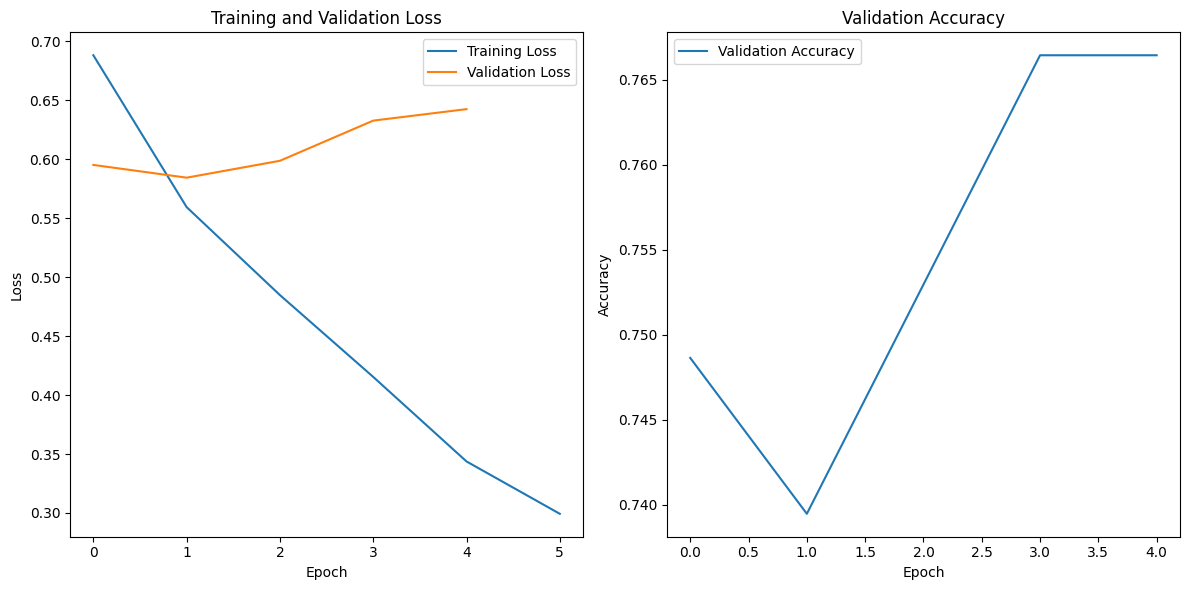

In [69]:
logs = trainer.state.log_history

# Extract the loss and accuracy
aug_train_loss = [log['loss'] for log in logs if 'loss' in log]
aug_eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
aug_eval_accuracy = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log]

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
epochs = range(0, len(eval_loss)+1)
plt.plot(epochs, aug_train_loss, label='Training Loss')
epochs = range(0, len(eval_loss))
plt.plot(epochs, aug_eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, aug_eval_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

F1 Score: 0.7395


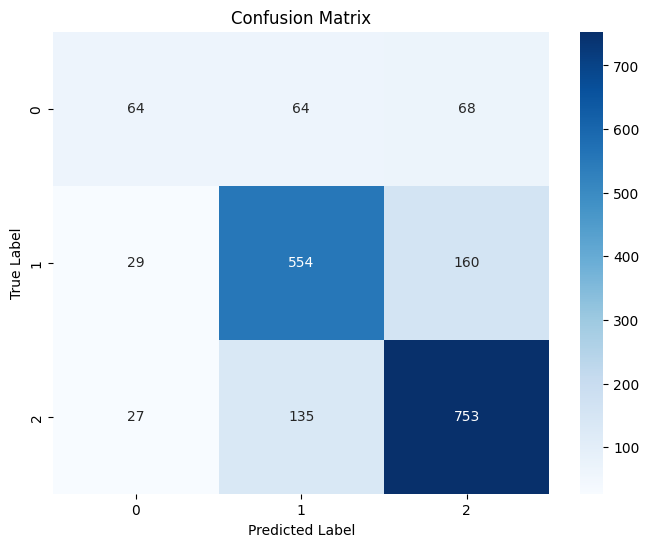

In [70]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


predictions = trainer.predict(valid_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
cm = confusion_matrix(labels, preds)

print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [80]:
# predictions = trainer.predict(valid_dataset)
# preds = np.argmax(predictions.predictions, axis=1)
# labels = predictions.label_ids

incorrect_indices = np.where(preds != labels)[0]

for i in range(5):
    print(f'mistake example {i+1}:')
    ind = incorrect_indices[i]
    print('text:',valid_dataset['text'][ind])
    print('predicted label:', preds[ind])
    print('actual label:', labels[ind])
# incorrect_texts = [valid_dataset[i]['text'] for i in incorrect_indices]
# incorrect_preds = preds[incorrect_indices]
# incorrect_labels = labels[incorrect_indices]

# print("Examples of incorrect predictions:")
# for i in range(min(5, len(incorrect_indices))):
#     print(f"Text: {incorrect_texts[i]}")
#     print(f"True Label: {incorrect_labels[i]}, Predicted Label: {incorrect_preds[i]}\n")


mistake example 1:
text: با اين چيزا نميتونه از Galaxy S III بهتر باشه
predicted label: 2
actual label: 0
mistake example 2:
text: از حساسیت 400 مقداری نویز در عکس ها مشاهده می شود اما همچنان جزئیات عکس ها خیلی خوب پیدا هستند.
predicted label: 0
actual label: 2
mistake example 3:
text: همه ميدانيم که اين گوشي از سيستم عامل ios6 پشتيباني ميکند سيستم عاملي که رييس شرکت سامسونگ در معرفي گلکسي نوت2 دربارش ميگويد:اين سيستم عامل بي نظير و دست نيافتني است و من ارزو دارم روزي از اين سيستم عامل بر روي گوشي هاي سامسونگ استفاده کنم.
predicted label: 1
actual label: 2
mistake example 4:
text: این دستگاه‌ها با گرد هم آوردن چند دستگاه به صورت یک جا،  هم فضای کمتری می‌گیرد و هم هزینه کمتری به خریداران خود تحمیل می‌کند.
predicted label: 1
actual label: 2
mistake example 5:
text: شايد بشه گفت براي بازي مناسب نيست .
predicted label: 2
actual label: 0


### Without Augmentation

In [46]:
train_dataset = Dataset.from_pandas(train_data)
valid_dataset = Dataset.from_pandas(test_data)

model_name = "HooshvareLab/bert-fa-zwnj-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(
        example['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

train_dataset = train_dataset.map(tokenize, batched=True)
valid_dataset = valid_dataset.map(tokenize, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
valid_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

model = get_model()

for name, param in model.named_parameters():
    if 'classifier' not in name and 'bert.encoder.layer.11' not in name:
        param.requires_grad = False



Map:   0%|          | 0/5561 [00:00<?, ? examples/s]

Map:   0%|          | 0/1854 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-zwnj-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
training_args = TrainingArguments(
    output_dir="./output",
    learning_rate=10e-5,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=2,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1504: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [48]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.654582,0.726537,0.726537,0.726537,0.726537
1,0.706600,0.609754,0.742718,0.742718,0.742718,0.742718
2,0.541500,0.607146,0.757821,0.757821,0.757821,0.757821
4,0.429300,0.621916,0.758360,0.758360,0.758360,0.758360


TrainOutput(global_step=1735, training_loss=0.5373589595387923, metrics={'train_runtime': 393.8792, 'train_samples_per_second': 70.593, 'train_steps_per_second': 4.405, 'total_flos': 1825217778779136.0, 'train_loss': 0.5373589595387923, 'epoch': 4.98921639108555})

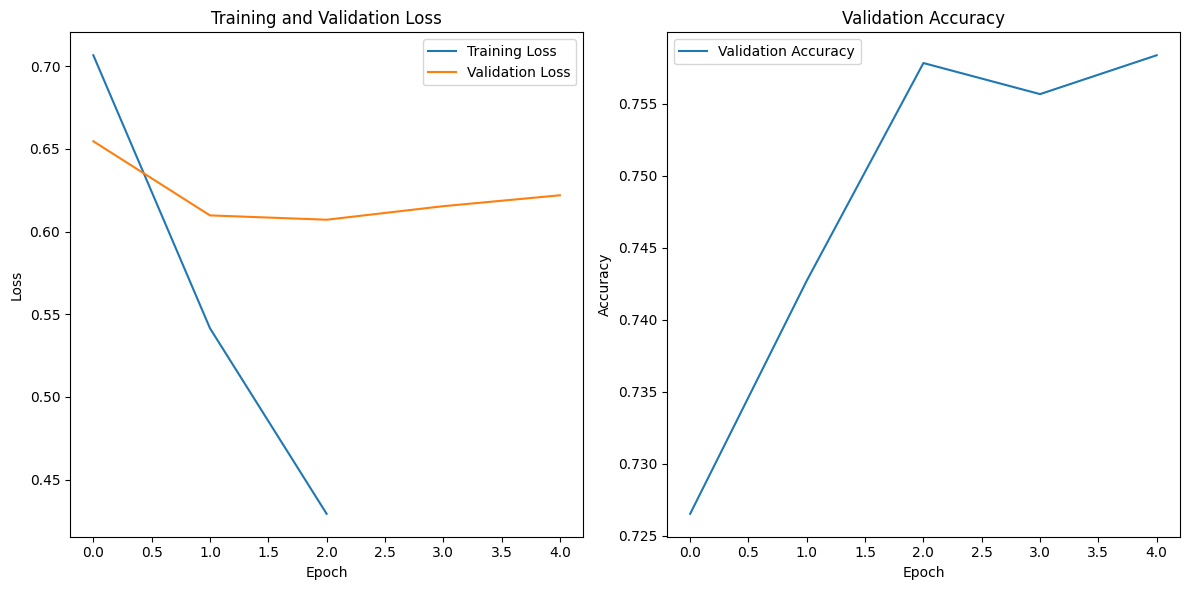

In [52]:
logs = trainer.state.log_history

# Extract the loss and accuracy
noaug_train_loss = [log['loss'] for log in logs if 'loss' in log]
noaug_eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
noaug_eval_accuracy = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log]

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
epochs = range(0, len(noaug_train_loss))
plt.plot(epochs, noaug_train_loss, label='Training Loss')
epochs = range(0, len(noaug_eval_loss))
plt.plot(epochs, noaug_eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, noaug_eval_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

F1 Score: 0.7578


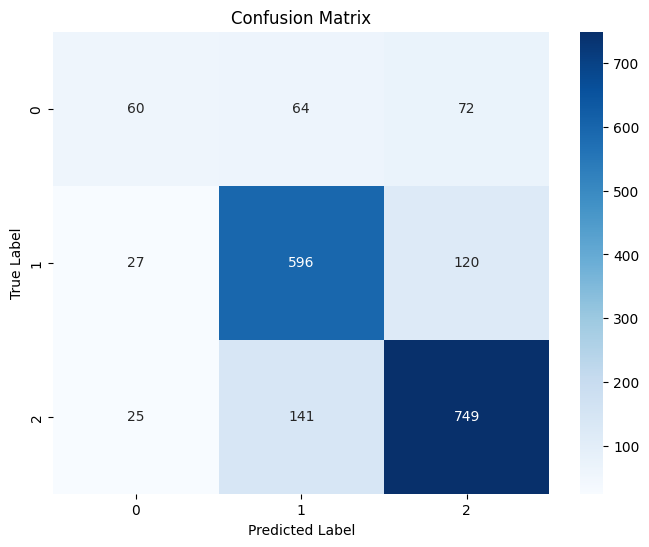

In [53]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


predictions = trainer.predict(valid_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
cm = confusion_matrix(labels, preds)

print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Comparison

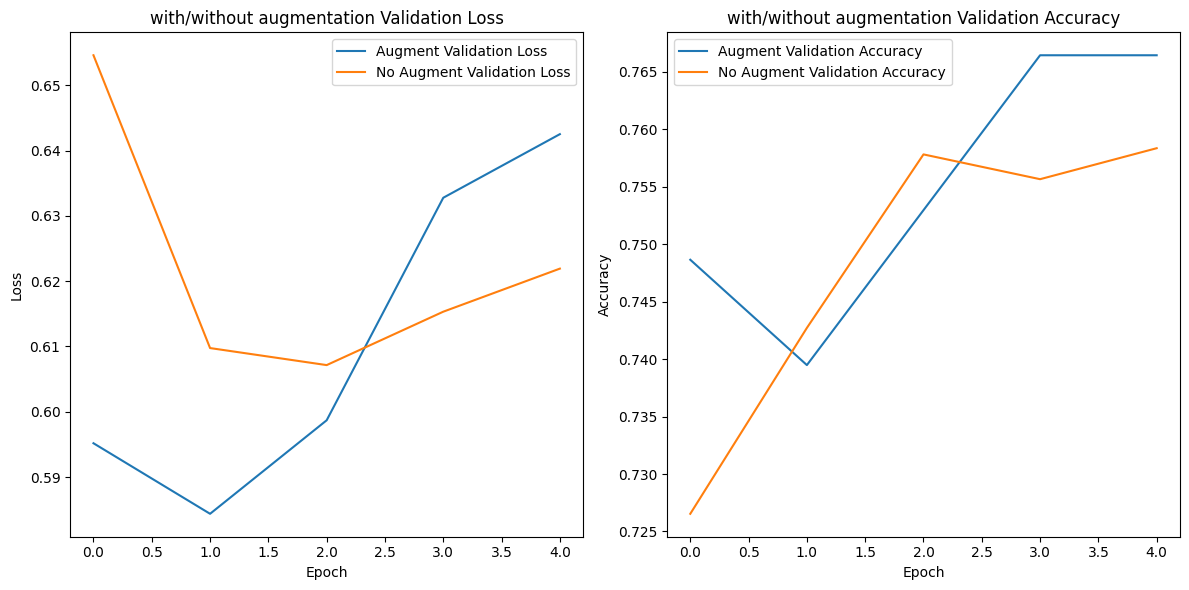

In [71]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
epochs = range(0, len(aug_eval_loss))
plt.plot(epochs, aug_eval_loss, label='Augment Validation Loss')
epochs = range(0, len(noaug_eval_loss))
plt.plot(epochs, noaug_eval_loss, label='No Augment Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('with/without augmentation Validation Loss')

plt.subplot(1, 2, 2)
epochs = range(0, len(aug_eval_accuracy))
plt.plot(epochs, aug_eval_accuracy, label='Augment Validation Accuracy')
epochs = range(0, len(noaug_eval_accuracy))
plt.plot(epochs, noaug_eval_accuracy, label='No Augment Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('with/without augmentation Validation Accuracy')

plt.tight_layout()
plt.show()